# Logarithmic Regularization: Dataset 3

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import plot_tree

from sklearn.metrics import r2_score, classification_report, confusion_matrix,           \
                            roc_curve, roc_auc_score, plot_confusion_matrix, f1_score,   \
                            balanced_accuracy_score, accuracy_score, mean_squared_error, \
                            log_loss
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier,    \
                                 Lasso, lasso_path
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

import scipy
from scipy import stats

import os
import shutil
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import itertools

import time
import tqdm
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

import PIL
import joblib
import json

# import mysgd

In [2]:
# Import user-defined modules
import sys
import imp
sys.path.append('/Users/arbelogonzalezw/Documents/ML_WORK/LIBS/Lockdown')
import tools_general as tg
import tools_pytorch as tp
import lockdown      as ld
imp.reload(tg)
imp.reload(tp)
imp.reload(ld)

<module 'lockdown' from '/Users/arbelogonzalezw/Documents/ML_WORK/LIBS/Lockdown/lockdown.py'>

## Read, clean, and save data

In [27]:
# Read X and y
folder = '/Users/arbelogonzalezw/Documents/ML_WORK/Project_Jerry_Lockdown/'
X = pd.read_csv(os.path.join(folder, 'dataset_13LungCancer/GSE137140_gene_profile.csv'), index_col=0)
dfy = pd.read_csv(os.path.join(folder, 'dataset_13LungCancer/GSE137140_output.csv'), index_col=1)

In [28]:
# Clean missing values and output classes
X.dropna(axis=1, how='any', inplace=True)

indx = dfy.index[dfy['disease state:ch1'] == 'Lung cancer, post-operation']
X.drop(axis='index', index=indx, inplace=True)
dfy.drop(axis='index', index=indx, inplace=True)

X.columns = X.columns.str.lower()
dfy.rename(columns={'disease state:ch1': 'disease_state'}, inplace=True)

# Set target
dfy.replace({'disease_state': {"Lung cancer, pre-operation": 1, "Non-cancer control": 0}}, inplace=True)
Y = pd.DataFrame(dfy['disease_state'])

In [33]:
# Split and save data set
xtrain, xvalid, xtest, ytrain, yvalid, ytest = tg.split_data(X, Y, seed1=0, seed2=42)
tg.save_data(X, xtrain, xvalid, xtest, Y, ytrain, yvalid, ytest, 'dataset/')
tg.save_list(X.columns.to_list(), 'dataset/X.columns')
tg.save_list(Y.columns.to_list(), 'dataset/Y.columns')

# 
print("- X size: {}\n".format(X.shape))
print("- xtrain size: {}".format(xtrain.shape))
print("- xvalid size: {}".format(xvalid.shape))
print("- xtest size: {}".format(xtest.shape))

- X size: (3744, 228)

- xtrain size: (2246, 228)
- xvalid size: (749, 228)
- xtest size: (749, 228)


## Load Data

In [3]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")
    
# Choose device
# torch.cuda.set_device(6)

-Type of precessor to be used: 'cpu'


In [4]:
# Read data
X, x_train, x_valid, x_test, Y, ytrain, yvalid, ytest = tp.load_data_clf('dataset/')
cols_X = tg.read_list('dataset/X.columns')
cols_Y = tg.read_list('dataset/Y.columns')

In [5]:
# Normalize data
xtrain, xvalid, xtest = tp.normalize_x(x_train, x_valid, x_test)

In [6]:
# Create dataloaders
dl_train, dl_valid, dl_test = tp.make_DataLoaders(xtrain, xvalid, xtest, ytrain, yvalid, ytest, 
                                                  tp.dataset_tabular, batch_size=10000)

(train, valid, test) = (1, 1, 1)


In [7]:
# NN architecture with its corresponding forward method
class MyNet(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNet, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(features, layer_sizes[0], bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(layer_sizes[0], layer_sizes[1], bias=True)
        )

# .Forward function
    def forward(self, x):
        x = self.classifier(x)
        return x

In [8]:
# Load best forward model
n_features = len(cols_X)
n_layers = [10, 2]
model = MyNet(n_features, n_layers)
model.eval()

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=228, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=2, bias=True)
  )
)

## Lockout (Log, beta = 0.7)

In [13]:
# TRAIN WITH LOCKDOWN
model = MyNet(n_features, n_layers)
model.load_state_dict(torch.load('./model_forward_valid_min.pth'))
model.eval()

regul_type = [('classifier.0.weight', 2), 
              ('classifier.2.weight', 2)]

regul_path = [('classifier.0.weight', True), 
              ('classifier.2.weight', False)]

t0_points = {'classifier.0.weight': 200}

lockout_log7 = ld.lockdown(model, lr=5e-3, 
                           regul_type=regul_type, 
                           regul_path=regul_path, 
                           t0_points=t0_points,
                           loss_type=2, tol_grads=1e-2, beta=0.7)

In [14]:
lockout_log7.train(dl_train, dl_valid, dl_test, epochs=10000, early_stop=15, tol_loss=1e-5,
                   train_how="sampling_t0")

t0:   0%|          | 0/200 [00:00<?, ?it/s]

{'classifier.0.weight': tensor(-754.0070, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (975)
{'classifier.0.weight': tensor(-754.3045, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (210)
{'classifier.0.weight': tensor(-754.6021, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (21)
{'classifier.0.weight': tensor(-754.8996, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (27)
{'classifier.0.weight': tensor(-755.1971, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (21)
{'classifier.0.weight': tensor(-755.4947, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (21)
{'classifier.0.weight': tensor(-755.7922, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (34)
{'classifier.0.weight': tensor(-756.0898, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (33)
{'classifier.0.weight': tensor(-756.3873, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (21)
{'classifier.0.weight': tensor(-756.6849, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (22)
{'classifier.0.weight': tensor(-756.9824, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (50)
{'classifier.0.weight': tensor(-757.2800, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (42)
{'classifier.0.weight': tensor(-757.5775, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (22)
{'classifier.0.weight': tensor(-757.8751, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (31)
{'classifier.0.weight': tensor(-758.1726, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (22)
{'classifier.0.weight': tensor(-758.4702, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (29)
{'classifier.0.weight': tensor(-758.7677, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (30)
{'classifier.0.weight': tensor(-759.0653, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (22)
{'classifier.0.weight': tensor(-759.3628, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (22)
{'classifier.0.weight': tensor(-759.6604, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (22)
{'classifier.0.weight': tensor(-759.9579, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (22)
{'classifier.0.weight': tensor(-760.2555, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (22)
{'classifier.0.weight': tensor(-760.5530, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (22)
{'classifier.0.weight': tensor(-760.8506, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (22)
{'classifier.0.weight': tensor(-761.1481, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (22)
{'classifier.0.weight': tensor(-761.4456, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (23)
{'classifier.0.weight': tensor(-761.7432, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (23)
{'classifier.0.weight': tensor(-762.0407, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (23)
{'classifier.0.weight': tensor(-762.3383, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (23)
{'classifier.0.weight': tensor(-762.6358, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (23)
{'classifier.0.weight': tensor(-762.9334, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (23)
{'classifier.0.weight': tensor(-763.2309, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (23)
{'classifier.0.weight': tensor(-763.5285, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (23)
{'classifier.0.weight': tensor(-763.8260, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (23)
{'classifier.0.weight': tensor(-764.1236, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (23)
{'classifier.0.weight': tensor(-764.4211, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (23)
{'classifier.0.weight': tensor(-764.7187, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (23)
{'classifier.0.weight': tensor(-765.0162, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (23)
{'classifier.0.weight': tensor(-765.3138, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (23)
{'classifier.0.weight': tensor(-765.6113, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (24)
{'classifier.0.weight': tensor(-765.9089, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (24)
{'classifier.0.weight': tensor(-766.2064, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (24)
{'classifier.0.weight': tensor(-766.5040, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (24)
{'classifier.0.weight': tensor(-766.8015, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (24)
{'classifier.0.weight': tensor(-767.0991, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (24)
{'classifier.0.weight': tensor(-767.3966, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (24)
{'classifier.0.weight': tensor(-767.6941, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (24)
{'classifier.0.weight': tensor(-767.9917, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (24)
{'classifier.0.weight': tensor(-768.2892, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (24)
{'classifier.0.weight': tensor(-768.5868, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (24)
{'classifier.0.weight': tensor(-768.8843, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (24)
{'classifier.0.weight': tensor(-769.1819, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (24)
{'classifier.0.weight': tensor(-769.4794, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (25)
{'classifier.0.weight': tensor(-769.7770, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (25)
{'classifier.0.weight': tensor(-770.0745, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (25)
{'classifier.0.weight': tensor(-770.3721, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (25)
{'classifier.0.weight': tensor(-770.6696, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (25)
{'classifier.0.weight': tensor(-770.9672, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (25)
{'classifier.0.weight': tensor(-771.2647, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (25)
{'classifier.0.weight': tensor(-771.5623, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (25)
{'classifier.0.weight': tensor(-771.8598, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (25)
{'classifier.0.weight': tensor(-772.1574, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (25)
{'classifier.0.weight': tensor(-772.4549, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (25)
{'classifier.0.weight': tensor(-772.7525, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (25)
{'classifier.0.weight': tensor(-773.0500, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (26)
{'classifier.0.weight': tensor(-773.3476, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (26)
{'classifier.0.weight': tensor(-773.6451, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (26)
{'classifier.0.weight': tensor(-773.9426, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (26)
{'classifier.0.weight': tensor(-774.2402, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (26)
{'classifier.0.weight': tensor(-774.5377, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (26)
{'classifier.0.weight': tensor(-774.8353, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (26)
{'classifier.0.weight': tensor(-775.1328, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (38)
{'classifier.0.weight': tensor(-775.4304, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (26)
{'classifier.0.weight': tensor(-775.7279, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (26)
{'classifier.0.weight': tensor(-776.0255, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (27)
{'classifier.0.weight': tensor(-776.3230, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (37)
{'classifier.0.weight': tensor(-776.6206, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (27)
{'classifier.0.weight': tensor(-776.9181, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (36)
{'classifier.0.weight': tensor(-777.2157, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (27)
{'classifier.0.weight': tensor(-777.5132, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (27)
{'classifier.0.weight': tensor(-777.8108, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (27)
{'classifier.0.weight': tensor(-778.1083, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (28)
{'classifier.0.weight': tensor(-778.4059, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (38)
{'classifier.0.weight': tensor(-778.7034, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (28)
{'classifier.0.weight': tensor(-779.0010, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (28)
{'classifier.0.weight': tensor(-779.2985, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (28)
{'classifier.0.weight': tensor(-779.5961, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (28)
{'classifier.0.weight': tensor(-779.8936, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (38)
{'classifier.0.weight': tensor(-780.1911, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (42)
{'classifier.0.weight': tensor(-780.4887, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (28)
{'classifier.0.weight': tensor(-780.7862, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (29)
{'classifier.0.weight': tensor(-781.0838, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (29)
{'classifier.0.weight': tensor(-781.3813, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (29)
{'classifier.0.weight': tensor(-781.6789, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (29)
{'classifier.0.weight': tensor(-781.9764, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (29)
{'classifier.0.weight': tensor(-782.2740, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (45)
{'classifier.0.weight': tensor(-782.5715, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (51)
{'classifier.0.weight': tensor(-782.8691, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (44)
{'classifier.0.weight': tensor(-783.1666, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (30)
{'classifier.0.weight': tensor(-783.4642, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (30)
{'classifier.0.weight': tensor(-783.7617, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (30)
{'classifier.0.weight': tensor(-784.0593, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (30)
{'classifier.0.weight': tensor(-784.3568, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (31)
{'classifier.0.weight': tensor(-784.6544, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (31)
{'classifier.0.weight': tensor(-784.9519, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (31)
{'classifier.0.weight': tensor(-785.2495, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (32)
{'classifier.0.weight': tensor(-785.5470, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (32)
{'classifier.0.weight': tensor(-785.8446, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (32)
{'classifier.0.weight': tensor(-786.1421, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (32)
{'classifier.0.weight': tensor(-786.4396, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (33)
{'classifier.0.weight': tensor(-786.7372, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (33)
{'classifier.0.weight': tensor(-787.0347, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (33)
{'classifier.0.weight': tensor(-787.3323, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (33)
{'classifier.0.weight': tensor(-787.6298, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (72)
{'classifier.0.weight': tensor(-787.9274, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (48)
{'classifier.0.weight': tensor(-788.2249, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (34)
{'classifier.0.weight': tensor(-788.5225, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (34)
{'classifier.0.weight': tensor(-788.8200, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (65)
{'classifier.0.weight': tensor(-789.1176, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (35)
{'classifier.0.weight': tensor(-789.4151, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (35)
{'classifier.0.weight': tensor(-789.7127, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (50)
{'classifier.0.weight': tensor(-790.0102, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (63)
{'classifier.0.weight': tensor(-790.3078, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (46)
{'classifier.0.weight': tensor(-790.6053, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (52)
{'classifier.0.weight': tensor(-790.9029, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (37)
{'classifier.0.weight': tensor(-791.2004, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (60)
{'classifier.0.weight': tensor(-791.4980, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (71)
{'classifier.0.weight': tensor(-791.7955, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (38)
{'classifier.0.weight': tensor(-792.0931, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (48)
{'classifier.0.weight': tensor(-792.3906, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (62)
{'classifier.0.weight': tensor(-792.6881, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (55)
{'classifier.0.weight': tensor(-792.9857, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (49)
{'classifier.0.weight': tensor(-793.2832, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (83)
{'classifier.0.weight': tensor(-793.5808, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (49)
{'classifier.0.weight': tensor(-793.8783, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (57)
{'classifier.0.weight': tensor(-794.1759, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (57)
{'classifier.0.weight': tensor(-794.4734, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (85)
{'classifier.0.weight': tensor(-794.7710, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (75)
{'classifier.0.weight': tensor(-795.0685, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (55)
{'classifier.0.weight': tensor(-795.3661, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (79)
{'classifier.0.weight': tensor(-795.6636, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (92)
{'classifier.0.weight': tensor(-795.9612, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (70)
{'classifier.0.weight': tensor(-796.2587, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (67)
{'classifier.0.weight': tensor(-796.5563, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (107)
{'classifier.0.weight': tensor(-796.8538, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (100)
{'classifier.0.weight': tensor(-797.1514, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (58)
{'classifier.0.weight': tensor(-797.4489, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (146)
{'classifier.0.weight': tensor(-797.7465, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (62)
{'classifier.0.weight': tensor(-798.0440, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (69)
{'classifier.0.weight': tensor(-798.3416, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (96)
{'classifier.0.weight': tensor(-798.6391, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (64)
{'classifier.0.weight': tensor(-798.9366, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (74)
{'classifier.0.weight': tensor(-799.2342, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (74)
{'classifier.0.weight': tensor(-799.5317, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (119)
{'classifier.0.weight': tensor(-799.8293, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (91)
{'classifier.0.weight': tensor(-800.1268, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (105)
{'classifier.0.weight': tensor(-800.4244, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (92)
{'classifier.0.weight': tensor(-800.7219, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (180)
{'classifier.0.weight': tensor(-801.0195, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (125)
{'classifier.0.weight': tensor(-801.3170, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (101)
{'classifier.0.weight': tensor(-801.6146, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (151)
{'classifier.0.weight': tensor(-801.9121, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (144)
{'classifier.0.weight': tensor(-802.2097, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (146)
{'classifier.0.weight': tensor(-802.5072, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (153)
{'classifier.0.weight': tensor(-802.8048, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (256)
{'classifier.0.weight': tensor(-803.1023, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (135)
{'classifier.0.weight': tensor(-803.3999, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (159)
{'classifier.0.weight': tensor(-803.6974, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (141)
{'classifier.0.weight': tensor(-803.9950, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (87)
{'classifier.0.weight': tensor(-804.2925, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (113)
{'classifier.0.weight': tensor(-804.5901, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (146)
{'classifier.0.weight': tensor(-804.8876, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (145)
{'classifier.0.weight': tensor(-805.1851, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (159)
{'classifier.0.weight': tensor(-805.4827, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (135)
{'classifier.0.weight': tensor(-805.7802, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (190)
{'classifier.0.weight': tensor(-806.0778, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (161)
{'classifier.0.weight': tensor(-806.3753, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (275)
{'classifier.0.weight': tensor(-806.6729, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (214)
{'classifier.0.weight': tensor(-806.9704, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (223)
{'classifier.0.weight': tensor(-807.2680, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (327)
{'classifier.0.weight': tensor(-807.5655, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (380)
{'classifier.0.weight': tensor(-807.8631, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (396)
{'classifier.0.weight': tensor(-808.1606, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (175)
{'classifier.0.weight': tensor(-808.4582, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (281)
{'classifier.0.weight': tensor(-808.7557, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (318)
{'classifier.0.weight': tensor(-809.0533, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (421)
{'classifier.0.weight': tensor(-809.3508, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (306)
{'classifier.0.weight': tensor(-809.6484, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (333)
{'classifier.0.weight': tensor(-809.9459, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (388)
{'classifier.0.weight': tensor(-810.2435, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (380)
{'classifier.0.weight': tensor(-810.5410, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (413)
{'classifier.0.weight': tensor(-810.8386, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (531)
{'classifier.0.weight': tensor(-811.1361, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (581)
{'classifier.0.weight': tensor(-811.4336, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (625)
{'classifier.0.weight': tensor(-811.7312, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (1239)
{'classifier.0.weight': tensor(-812.0287, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (2542)
{'classifier.0.weight': tensor(-812.3263, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (4679)
{'classifier.0.weight': tensor(-812.6238, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = False (10000)
{'classifier.0.weight': tensor(-812.9214, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (168)
{'classifier.0.weight': tensor(-813.2189, dtype=torch.float64), 'classifier.2.weight': tensor(-4.9737)} {'classifier.0.weight': tensor(-813.2189)}


Epochs1:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True (15)
Best validation at iteration = 15


In [15]:
# Save model, data
tp.save_model(lockout_log7.model_best_valid, 'model_lockout_valid_min_log7.pth')
tp.save_model(lockout_log7.model_last, 'model_lockout_last_log7.pth')
lockout_log7.path_data.to_csv('data_lockout_log7.csv')

In [17]:
# L1
nn = int(2e2)
data_tmp = pd.read_csv('data_lockdown_l1.csv', index_col=0)
data_lockout_l1 = pd.DataFrame(columns=['sparcity', 'train_accu', 'valid_accu', 'test_accu', 't0_used'])
xgrid, step = np.linspace(0., 1., num=nn,endpoint=True, retstep=True)
for x in xgrid:
    msk = (data_tmp['sparcity__classifier.0.weight'] >= x) &    \
          (data_tmp['sparcity__classifier.0.weight'] < x+step)
    train_accu = data_tmp.loc[msk, 'train_accu'].mean()
    valid_accu = data_tmp.loc[msk, 'valid_accu'].mean()
    test_accu  = data_tmp.loc[msk, 'test_accu'].mean()
    t0_used = data_tmp.loc[msk, 't0_used__classifier.0.weight'].mean()
    data_lockout_l1 = data_lockout_l1.append({'sparcity': x, 
                                             'train_accu': train_accu, 
                                             'valid_accu': valid_accu, 
                                             'test_accu': test_accu, 
                                             't0_used': t0_used}, ignore_index=True)
data_lockout_l1.dropna(axis='index', how='any', inplace=True)

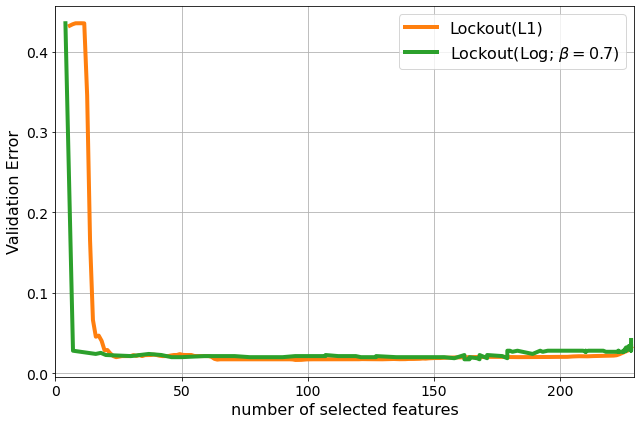

In [31]:
# beta=0.7
data_lockout7 = pd.read_csv('data_lockout_log7.csv', index_col=0)
data_lockout7 = data_lockout7.sort_values(by=['sparcity__classifier.0.weight'], 
                                            ascending=True)

fig, axes = plt.subplots(figsize=(9,6))

axes.plot(n_features*data_lockout_l1['sparcity'], 
          1.0 - data_lockout_l1['valid_accu'], 
          "-", linewidth=4, markersize=10, label="Lockout(L1)", 
          color="tab:orange")
axes.plot(n_features*data_lockout7['sparcity__classifier.0.weight'], 
          1.0 - data_lockout7['valid_accu'], 
          "-", linewidth=4, markersize=10, label=r'Lockout(Log; $\beta=0.7$)', 
          color="tab:green")

axes.grid(True, zorder=2)
axes.set_xlabel("number of selected features", fontsize=16)
axes.set_ylabel("Validation Error", fontsize=16)
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_xlim(0, 229)
axes.legend(fontsize=16)

plt.tight_layout()
plt.savefig('error_vs_features_log_dataset13.pdf', bbox_inches='tight')
plt.show()